In [24]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.utils.testing import all_estimators
from sklearn.metrics import  r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

# signate 飯田産業 土地の販売価格の推定 コンペ

In [3]:
#データ読み込み
train_genba= pd.read_csv( 'train_genba.tsv', delimiter='\t' )
train_goto= pd.read_csv( 'train_goto.tsv', delimiter='\t' )
test_genba= pd.read_csv( 'test_genba.tsv', delimiter='\t' )
test_goto= pd.read_csv( 'test_goto.tsv', delimiter='\t' )

In [4]:
train_genba.head(5)

,pj_no,jukyo,chiseki_js_hb,chiseki_kb_hb,yoto1,yoto2,kempei1,kempei2,yoseki1,yoseki2,...,bas_toho1,eki_kyori1,bastei_nm1,teiho1,rosen_nm2,eki_nm2,bas_toho2,eki_kyori2,bastei_nm2,teiho2
0,0,埼玉県朝霞市泉水,109.26,109.10,工業地域,NaN,60,0.0,200,0.0,...,徒歩,17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,埼玉県川越市大字的場,136.15,136.00,第一種低層住居専用地域,NaN,60,0.0,200,0.0,...,徒歩,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,埼玉県川口市安行原,86.92,86.52,第一種低層住居専用地域,NaN,50,0.0,100,0.0,...,徒歩,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,埼玉県草加市松江,164.91,164.07,工業地域,NaN,60,0.0,200,0.0,...,徒歩,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,埼玉県新座市野火止,403.58,403.58,第一種低層住居専用地域,NaN,50,0.0,80,0.0,...,徒歩,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [166]:
train_genba["eki_kyori1"].describe()

count    2781.000000
mean       15.227976
std         7.234546
min         1.000000
25%        10.000000
50%        14.000000
75%        19.000000
max        90.000000
Name: eki_kyori1, dtype: float64

In [5]:
#最寄駅までの時間をカテゴリ化
eki_kyori_bins = [0,5,10,15,20,25,30,100]
group_names = ["A", "B", "C", "D","E","F","G"]

In [6]:
eki_kyori_cut_data= pd.cut(train_genba.eki_kyori1,eki_kyori_bins,labels= group_names)
eki_kyori_cut_data2= pd.cut(test_genba.eki_kyori1,eki_kyori_bins,labels= group_names)

In [7]:
pd.value_counts(eki_kyori_cut_data)

C    823
B    664
D    589
E    338
A    152
F    142
G     73
Name: eki_kyori1, dtype: int64

In [8]:
train_genba["rank"] = eki_kyori_cut_data
test_genba["rank"] =eki_kyori_cut_data2

In [9]:
train_genba["toho"] = train_genba['bas_toho1'].str.cat(train_genba['rank'])
test_genba["toho"] = test_genba['bas_toho1'].str.cat(test_genba['rank'])



In [11]:
#特徴量選択
df = train_genba[["pj_no","yoto1","hw_status","toshikuiki1","koji_hb","sho_super","toho"]]
tdf=test_genba[["pj_no","yoto1","hw_status","toshikuiki1","koji_hb","sho_super","toho"]]
df2 = train_goto[["pj_no","keiyaku_pr","hiatari","tc_mseki","levelplan","kobetsu1"]]
tdf2 = test_goto[["pj_no","hiatari","tc_mseki","levelplan","kobetsu1"]]
df = pd.merge(df2,df,on="pj_no")
tdf =pd.merge(tdf2,tdf,on="pj_no")
df["tf"]=0
tdf["tf"]=1
all_data = df.append(tdf)


In [12]:
#0,1に変換
df=df.fillna(0)
df= df.replace('○', 1)
tdf=df.fillna(0)
tdf= df.replace('○', 1)

# 最寄りの駅からの近さで統計量出す
## 交通の便が良さそうな所は平均価格も高くなる

In [14]:
kakaku = df.filter(items=["toho","keiyaku_pr"]).groupby("toho").describe()
kakaku

keiyaku_pr                                                      \
          count          mean           std         min         25%   
toho                                                                  
バスA        68.0  2.855147e+07  5.328199e+06  15000000.0  24950000.0   
バスB       610.0  2.637146e+07  6.056641e+06   3500000.0  22525000.0   
バスC       396.0  2.693631e+07  5.220897e+06  13200000.0  23300000.0   
バスD       229.0  2.613139e+07  5.035966e+06   7900000.0  22800000.0   
バスE        63.0  2.326016e+07  4.724193e+06  13800000.0  20150000.0   
バスF        15.0  2.259080e+07  6.816156e+06   7200000.0  22000000.0   
バスG        10.0  2.046000e+07  4.155639e+06  14300000.0  18050000.0   
徒歩A       282.0  3.034153e+07  8.737436e+06  11800000.0  23575000.0   
徒歩B       888.0  3.015834e+07  7.884726e+06  13100000.0  24000000.0   
徒歩C      1502.0  2.851100e+07  7.448397e+06   2800000.0  23800000.0   
徒歩D      1118.0  2.820875e+07  6.178388e+06   3600000.0  24000000.0   
徒歩E       705.0  2.635198e+07  6.108670e+06   3000000.0  22500000.0   
徒歩F       354.0  2.648731e+07  5.139199e+06  16400000.0  22900000.0   
徒歩G       153.0  2.488876e+07  5.275768e+06  13800000.0  21800000.0   
車A         11.0  2.004545e+07  2.391386e+06  17300000.0  18300000.0   
車B         40.0  2.524425e+07  4.514631e+06  11990000.0  22950000.0   
車C         10.0  2.365000e+07  4.451279e+06  17000000.0  22000000.0   
車D          2.0  2.075000e+07  1.060660e+06  20000000.0  20375000.0   
車E          5.0  1.988000e+07  2.519325e+06  16000000.0  18900000.0   

                                          
             50%         75%         max  
toho                                      
バスA   28800000.0  31750000.0  40600000.0  
バスB   26600000.0  30800000.0  44000000.0  
バスC   26500000.0  30500000.0  47980000.0  
バスD   26000000.0  29800000.0  39800000.0  
バスE   23500000.0  25800000.0  35000000.0  
バスF   24000000.0  26600000.0  31100000.0  
バスG   20300000.0  22500000.0  29200000.0  
徒歩A   28850000.0  36800000.0  58900000.0  
徒歩B   29800000.0  35541000.0  57500000.0  
徒歩C   27707000.0  32725000.0  62800000.0  
徒歩D   27800000.0  32075000.0  52980000.0  
徒歩E   26000000.0  30000000.0  60980000.0  
徒歩F   26000000.0  29272500.0  41300000.0  
徒歩G   24800000.0  28500000.0  39900000.0  
車A    19000000.0  20950000.0  24500000.0  
車B    24895000.0  27850000.0  36800000.0  
車C    22650000.0  25175000.0  33500000.0  
車D    20750000.0  21125000.0  21500000.0  
車E    20500000.0  22000000.0  22000000.0

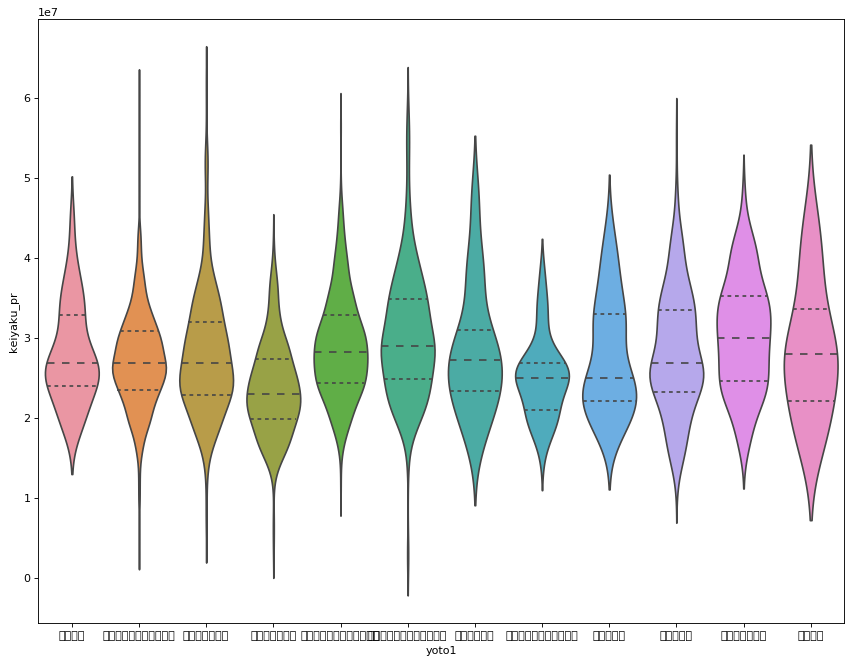

In [15]:
import seaborn as sns
plt.figure(figsize=(13,10),dpi=80)
sns.violinplot(x="yoto1",y="keiyaku_pr",data=df,scale="width",inner="quartile")
#grid = sns.FacetGrid(df,hue="gas",size=10)
#grid.map(plt.scatter,"gas","keiyaku_pr")
#plt.show()
#kakaku = df.filter(items=["gas","keiyaku_pr"]).groupby("gas").describe()
#kakaku

In [16]:
#ダミー変数化
all_data2=pd.get_dummies(all_data)
all_data2.head()

,keiyaku_pr,koji_hb,pj_no,tc_mseki,tf,hiatari_悪い,hiatari_普通,hiatari_良い,hw_status_その他,hw_status_山林,...,yoto1_指定のない区域,yoto1_準住居地域,yoto1_準工業地域,yoto1_第一種中高層住居専用地域,yoto1_第一種低層住居専用地域,yoto1_第一種住居地域,yoto1_第二種中高層住居専用地域,yoto1_第二種低層住居専用地域,yoto1_第二種住居地域,yoto1_近隣商業地域
0,39800000.0,188000,0,109.26,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,22300000.0,84900,1,136.11,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,19800000.0,116000,2,87.07,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,33990000.0,122000,3,163.75,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,30800000.0,179000,4,111.51,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [17]:
train = all_data2[all_data2["tf"]==0]
test = all_data2[all_data2["tf"]==1]



(array([  4.,   2.,   6.,  11.,  15.,  32.,  94., 245., 426., 553., 754.,
        882., 757., 721., 535., 452., 324., 225., 144., 100.,  66.,  41.,
         17.,  10.,  14.,  12.,   8.,   3.,   4.,   4.]),
 array([ 2800000.,  4800000.,  6800000.,  8800000., 10800000., 12800000.,
        14800000., 16800000., 18800000., 20800000., 22800000., 24800000.,
        26800000., 28800000., 30800000., 32800000., 34800000., 36800000.,
        38800000., 40800000., 42800000., 44800000., 46800000., 48800000.,
        50800000., 52800000., 54800000., 56800000., 58800000., 60800000.,
        62800000.]),
 <a list of 30 Patch objects>)

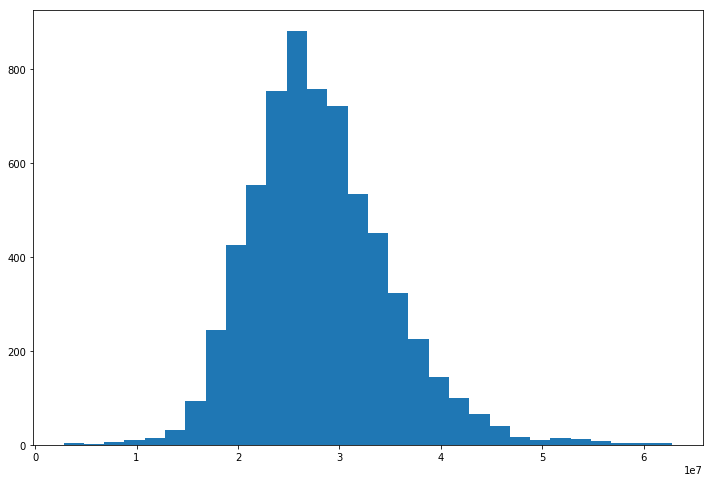

In [18]:
#販売価格のヒスト
plt.figure(figsize=(12, 8))
plt.hist(train["keiyaku_pr"],bins=30)

(array([4.000e+00, 8.700e+01, 2.350e+02, 1.361e+03, 1.726e+03, 1.294e+03,
        7.110e+02, 3.790e+02, 2.470e+02, 1.330e+02, 3.600e+01, 1.900e+01,
        2.000e+01, 9.500e+01, 3.400e+01, 2.800e+01, 1.600e+01, 1.800e+01,
        8.000e+00, 2.000e+00, 2.000e+00, 3.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([ 28.2       ,  48.72633333,  69.25266667,  89.779     ,
        110.30533333, 130.83166667, 151.358     , 171.88433333,
        192.41066667, 212.937     , 233.46333333, 253.98966667,
        274.516     , 295.04233333, 315.56866667, 336.095     ,
        356.62133333, 377.14766667, 397.674     , 418.20033333,
        438.72666667, 459.253     , 479.77933333, 500.30566667,
        520.832     , 541.35833333, 561.88466667, 582.411     ,
        602.93733333, 623.46366667, 643.99      ]),
 <a list of 30 Patch objects>)

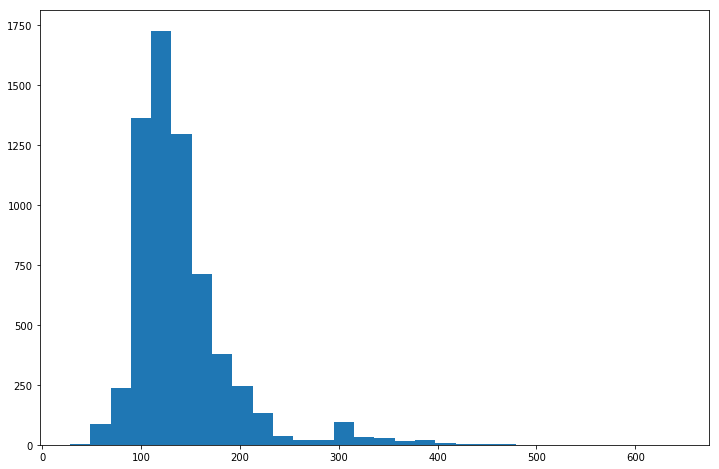

In [20]:
#土地面積のヒスト
plt.figure(figsize=(12, 8))
plt.hist(train["tc_mseki"],bins=30)

# 土地の面積と販売価格は相関があまりない

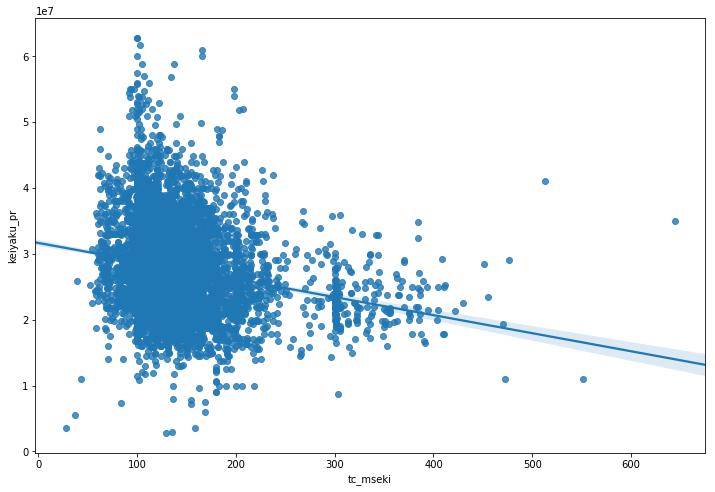

In [21]:
#df.info()
import seaborn as sns
train
plt.figure(figsize=(12, 8))
sns.regplot(x="tc_mseki", y="keiyaku_pr", data=train)
#plt.scatter( train["chiseki_js_hb"],train["keiyaku_pr"])

# 公示価格と販売価格の相関

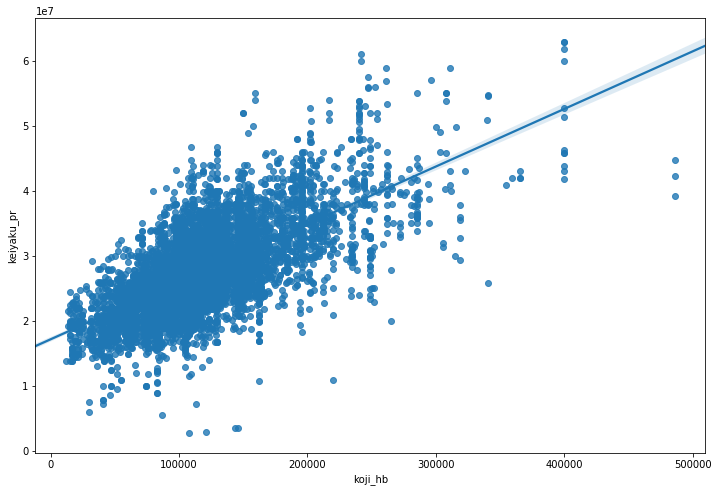

In [22]:
plt.figure(figsize=(12, 8))
sns.regplot(x="koji_hb", y="keiyaku_pr", data=train)

In [23]:

import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
X = train.drop(["pj_no","tf","keiyaku_pr"],1)
y = train.keiyaku_pr
test= test.drop(["keiyaku_pr","tf","pj_no"],1)


In [241]:
reg = xgb.XGBRegressor()
reg_cv = GridSearchCV(reg, {'max_depth': [2,4,6], 'n_estimators': [50,100,200]}, verbose=1)
reg_cv.fit(X, y)
print (reg_cv.best_params_, reg_cv.best_score_)

/Users/katoushinichi/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/katoushinichi/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Fitting 3 folds for each of 9 candidates, totalling 27 fits
[00:06:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/katoushinichi/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:06:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/katoushinichi/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:06:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/katoushinichi/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:06:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/katoushinichi/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:06:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/katoushinichi/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:06:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/katoushinichi/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:06:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/katoushinichi/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:06:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/katoushinichi/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:06:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/katoushinichi/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:06:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/katoushinichi/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:06:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/katoushinichi/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:06:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/katoushinichi/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:06:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/katoushinichi/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:06:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/katoushinichi/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:06:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/katoushinichi/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:06:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/katoushinichi/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:06:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/katoushinichi/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:07:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/katoushinichi/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:07:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/katoushinichi/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:07:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/katoushinichi/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:07:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/katoushinichi/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:07:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/katoushinichi/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:07:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/katoushinichi/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:07:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/katoushinichi/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:07:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/katoushinichi/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:07:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/katoushinichi/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:07:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:   48.9s finished
/Users/katoushinichi/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/katoushinichi/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[00:07:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'max_depth': 4, 'n_estimators': 200} 0.5731197580770151


In [242]:
reg = xgb.XGBRegressor(**reg_cv.best_params_)
reg.fit(X, y)

[00:08:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [251]:
#from sklearn import linear_model
#clf = linear_model.Lasso()
#clf1 = linear_model.Ridge()

# 学習
#clf.fit(X, y)


/Users/katoushinichi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [259]:
#from sklearn.preprocessing import StandardScaler
#from sklearn.svm import SVR
#scaler = StandardScaler()
#X_norm = scaler.fit_transform(X)
# テストデータも標準化
#Xtest_norm = scaler.transform(test)
#clf1.coef_
#red1=clf.predict(test)
#test= test.drop(["keiyaku_pr","tf","pj_no"],1)
#test.shape
#X
#regr = SVR(kernel="linear")
#regr.fit(X_norm, y)

/Users/katoushinichi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/katoushinichi/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/katoushinichi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='linear', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

In [260]:
#test = test.drop(["pj_no","tf","keiyaku_pr"],1)
pred =regr.predict(test)


In [261]:
sample = pd.read_csv("sample_submit.tsv",delimiter='\t',header=None)
sample.info()
sample[1] = pred
#sample[1] = red1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4273 entries, 0 to 4272
Data columns (total 2 columns):
0    4273 non-null object
1    4273 non-null int64
dtypes: int64(1), object(1)
memory usage: 66.8+ KB


In [262]:
sample.to_csv("submit9.tsv",index=None,header=None,sep='\t' )

In [25]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=123)

In [ ]:
for(name,algorithm) in allalgo:
    clf=algorithm()
    clf.fit(X_train,y_train)
    pred=clf.predict(X_test)
    print(name,"R2 =" ,r2_score(y_test,pred))